#Среда CarRacing

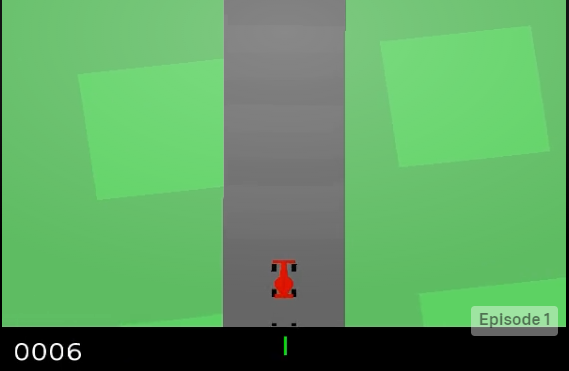

**Правила игры**

Агент должен управлять машиной, которая должна не съезжать с трассы и дойти до конца за минимальное время. Агент может управлять тремя параметрами:

* Угл поворота (скалярное число от -1 до +1)

* Газ (скалярное число от 0 до 1)

* Тормоз(скалярное число от 0 до 1)

Агент получает награду 1000/N за каждый новый участок дороги, через который он проезжает (N это количество участков дороги которые сгенерились). Также, агент получает награду -0.1 за каждую секунду времени, которая проходит. Эпизод завершается автоматический через 1000 действий.

Т.е. агент проезжает всю трассу за 600 действий, он получит суммарную награду (1000 - 0.1 * 600) = 940.

**Особенности среды - непрерывные действия**

Впервые в нашем курсе по обучению с подкреплением, агент работает не с дискретными действиями, а с *непрерывными* (т.е. ускорение может быть 0.997 или 0.998, 0.999, и тд.) Как было упомянуто в теоретической части занятия, существует целый ряд алгоритмов, которые способны с подобными задачами. В этом ноутбуке мы рассмотрим алгоритм оптимизации ближайщей политики, но именно в контексте непрерывных действий.

Примечание: алгоритм оптимизации ближайщей политики - это один из алгоритмов актёра-критика, т.е. базовый алгоритм актёр-критик также способен справляться с подобными задачами.




In [ ]:
# Будем обращаться к линукс-ядру напрямую с помощью команд на "!"
# Будем устанавливать окружение из пакета Stable Baseline для OpenAI (для того, чтобы можно было использовать движок в колабе)
# Код, представленный в документации разработчика
!apt install swig cmake libopenmpi-dev zlib1g-dev # cmake - сборка - аналог GNU Make, но с другим синтаксисом, libopenmpi-dev распределённые вычисления в кластере для дебиан, zlib1g-dev - сжатие траффика
!pip install stable-baselines==2.5.1 box2d box2d-kengz # устанавливаем непосредственно сам stable baseline и движок box2d

# если убрать " > /dev/null 2>&1" то работа сервера будет выведена на экран, а этой командой перемещаем все в фоновый режим
!pip install gym pyvirtualdisplay > /dev/null 2>&1 # установка пакета для рендера видео
!pip install xvfbwrapper # установка обертки для пакета, который позволит воспроизводить видео в ячейке колаба  
!apt-get update # обновляем все пакеты до новейшей версии, чтобы все пакеты "подружились"
!sudo apt-get install xvfb # установка удаленного сервера, благодаря которому видео будет воспроизводиться в ячейке колаба
!apt-get install xdpyinfo # пакет для вывода процессов, происходящих на сервере

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libopenmpi-dev is already the newest version (2.1.1-8).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-

Подключаем нужные библиотеки:

In [ ]:
import gym         # Load the Gym module from OpenAi, which is an environment for reinforcement learning
import numpy as np # Import numpy
import tensorflow as tf                   #Импортируем тензорфлоу
import tensorflow.keras as keras          #Импортируем керас как отдельный модуль от тензорфлоу
from tensorflow.keras.models import *     #Испортируем все воспомогательные функции для создания, сохранения, и загрузки моделей кераса
from tensorflow.keras.layers import *     #Импортируем все слои кераса
from tensorflow.keras.optimizers import * #Импортируем все оптимизаторы из кераса
from tensorflow.keras import backend as K #Импортируем бекэнд Кераса для самописных функций ошибки 
from pyvirtualdisplay import Display      #Импортируем модуль для создания окна дисплея (необходим для запуска данной среды)
import matplotlib.pyplot as plt           #Импортируем модуль для визуализации данных
import math                               #Импортируем модуль math для значения pi
import cv2                                #Импортируем библиотеку cv2 для обработки кадров игры
import pickle                             #Импортируем модуль pickle для сохранения и загрузки файлов
from google.colab import output           #Импортируем функцию для управления вывода в колаб-ячейках
import gc                                 #Импортируем модуль для очищения ОЗУ от лишней информации, которая появляется из-за утечек памяти в среде
 
#Задаем команду для matplotlib чтобы выводы ячеик были совместимы с IPython 
%matplotlib inline

In [ ]:
# Создаем объект дисплей, таким образом, симуляцию можно будет наблюдать в колабе
display = Display(visible=0, size=(1400, 900))
display.start()

#Желательно (но не обязательно) запустить эту команду, чтобы тензорфлоу работал быстрее.
#Нужно отметить, что это отключает некоторые возможности тензорфлоу (которые не используются в данном ноутбуке)
tf.compat.v1.disable_eager_execution()

Подключаем гугл-диск:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Гиперпараметры

В отдельной ячейке, мы зададим все гиперпараметры для нашего алгоритма.

Мы уже видели многие из этих гиперпараметров в ранних занятиях, но именно в этом ноутбуке появляются два новых гиперпараметра:

**lambda** 

  Этот гиперпараметр вовсем не обязательно использовать, однако он часто помогает алгоритму обучаться более стабильно и быстрее. Lambda используется в функции подсчета общей оценки преймущества (general advantage estimates). 

  По сути, lambda меняет саму цель, к которой алгоритм стремиться. Более высокие значения lambda заставляют алгоритм больше учитывать дисперсию целевых значений, тем временем как низкие значения делают упор на предвзятость. Значение `lambda = 0.9` используется очень часто в литературе.

**log_standard_deviation**

  Этот гиперпараметр используется исключительно в работе с непрерывными действиями. 

  При выборе действия, мы будем добавлять некий 'шум', который необходим для того, чтобы агент исследовал среду и обучался. log_standard_deviation контролирует величину данного шума (шум будет создаваться через нормальное распределение, чьё стандартное отклонение равно экспоненту данного параметра). 

`log_standard_deviation = -1` означает, что \begin{align} σ = e^{-1} =  \frac{1}{e} \end{align}

(где **σ** обозначает стандартное отклонение рандомного шума).

In [ ]:
loss_clip_value = 0.2           #Значение при котором отрезаем значение ошибки
gamma = 0.98                    #Коэффициент дисконтирования наград
lamda = 0.9                     #НОВЫЙ ГИПЕРПАРАМЕТР - 'сглаживает' обработанные награды
epochs_per_iteration = 10       #Количество эпох на котором мы обучаем алгоритм после каждого пакета
log_standard_deviation = -1.0   #НОВЫЙ ГИПЕРПАРАМЕТР - Логарифм стандартного отклонение, которое будет определять вариативность в выборе непрерывных действий
batch_size = 256                #Количество состояний/действий/наград в каждом пакете
num_frames = 4                  #Количество кадров в одном состоянии
num_actions_per_step = 8        #Количество действий, которые будем повторять при каждом действии (это помогает уменьшить пространство действий)

##Константы

Дальше, мы создадим образ нашей игровой среды, и воспользуемся ею чтобы задать несколько констант.

In [ ]:
root_path = '/content/drive/My Drive/pretrained_networks' #Директория куда будем сохранять все файлы

env_name = 'CarRacing-v0'                 #Задаем название среды с которой будем работать
env = gym.make(env_name)                  #Создаем образ игровой среды
action_size = env.action_space.shape[0]   #Записываем количество действий в среде
state_size = (96, 96, num_frames)         #Записываем размерность состояния среды
env.close()                               #Закрываем образ игровой среды

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


#Код для обучения алгоритма

### Функции для подсчета логарифма правпободобия

Ниже указанные функции обя выполняют одну суть - они подсчитывают логарифм оценки правдоподобия между двух распределений (действия которая предсказала сеть и реальные действия после добавления шума).

Одна из этих функций использует numpy-массивы, тем временем как другая использует keras-тензоры. Сама логика вычислений одинаковая, нам лишь нужны разные типы данных для разных подсчетов позже. 

Возможно, у Вас возникнет вопрос: зачем нам нужно считать логарифм оценки правдоподобия, почему вместо этого не посчитать само значение и затем просто взять его логарифм через `K.log()`. Можно, конечно, так сделать - но вычисление логарифма требует больше вычислительных ресурсов, и по этому в таком случае код будет выполняться медленее.

In [ ]:
#Функция которая считает логарифм оценки правдоподобия между двумя распределениями с keras-тензорами
def log_likelihood_keras(actions, predictions): 
  #Применяем уравнение -> P(x;μ,σ) = -((X - Y)^2 / (2*σ^2)) + 2*ln(σ) + ln(2*π)
  squared_difference = (actions - predictions)**2 #Записываем (X - Y)^2 в одну переменную
  squared_std = K.exp(log_standard_deviation)**2  #Записываем σ^2 в одну переменную

  predict_sum = squared_difference/(-2.0 * squared_std) - log_standard_deviation - K.log((2.0*math.pi)**0.5) #Считаем логарифм оценки правдоподобия
  return K.sum(predict_sum, axis=1) #Возвращаем сумму всех оценок за каждое действие

#Функция которая считает логариым оценки правдоподобия между двумя распределениями с numpy-массивами
def log_likelihood_numpy(actions, predictions): 
  #Применяем уравнение -> P(x;μ,σ) = -((X - Y)^2 / (2*σ^2)) + 2*ln(σ) + ln(2*π)
  squared_difference = (actions - predictions)**2 #Записываем (X - Y)^2 в одну переменную
  squared_std = np.exp(log_standard_deviation)**2 #Записываем σ^2 в одну переменную

  predict_sum = squared_difference/(-2.0 * squared_std) - log_standard_deviation - np.log((2.0*np.pi)**0.5) #Считаем логарифм оценки правдоподобия
  return np.sum(predict_sum, axis=1) #Возвращаем сумму всех оценок за каждое действие

##Функции ошибки

Также как в предыдущем ноутбуке, нам нужно создать две отдельные функции ошибки - функцию для обучения актёра и функцию для обучения критика.

Нужно отметить, что обе функции ошибки немного отличаются в силу того, что теперь мы работаем с непрерывными действиями.

**Функция ошибки актёра**

Для подсчета значения этой функции, нам нужны следующие входные данные:

* Значения преймущества (считаются внутри другой функции)
* оценки правдоподобия для действий, которые были приняты в эпизоде (считаются во время генерации эпизода)
* Действия, которые были приняты в эпизоде
* Действия, которые предсказывает актёр (y_pred)

Первые три выше-указанных значений соеденяются в единный массив (y_true), и затем распаковываются внутри самой функции ошибки. Это делается потому, что Керасовские функции ошибки могут принимать ровно две переменные на вход (y_true и y_pred).

Также как функция ошибки БОП с предыдущей части занятия, данная функция сперва считает соотношение вероятностей - в данном случае, это соотношение оценок правпободобия с эпизода, и оценками правпободобия с предсказаниями текущего актёра (примечание: они будут одинаковыми в первой эпохе обучения, но затем будут рассходиться). 

Затем, соотношение этих значений отрезается между предустановленными значениями, так чтобы (1 - C) <= R <= (1 + C) (где C это гиперпараметр, равен 0.2 по умолчанию, и R это соотношение вероятностей).

Функция ошибки актёра являются минимумом между: `значениям преймущества х соотношений оценок правдоподобия`, и `значениям преймущества х урезанные соотношения правдоподобностей`. Таким образом, происходит один большой шаг градиентного спуска в первой эпохе, и затем происходит ряд маленьких, более 'осторожных' шагов в последующих эпохах.

**Функция ошибки критика**

Данная функция ошибки критика использует по сути ту же логику, как и функция ошибки актёра: функция создана так, чтобы происходил один большой шаг обучения в первой эпохе, и затем происходил ряд маленьких, более остароных шагов 'дообучения'.

Вспоминаем что модель критика всегда пытается предсказать значения состояний. Данная функция принимает следующие входные данные:

* Целевые значения состояний (считаются алгоритмический с учётом наград)
* Старые значения состояний (предсказываются критиком перед раундом обучения)
* Текущие предсказания критика (y_pred)

Функция считает "урезанные" значения, которые равны сумме предсказания критика, и урезанными разницами между текущими предсказаниями и старыми значениями (для урезания значений также используется (1 - C) <= ΔV <= (1 + C) (где C это гиперпараметр, равен 0.2 по умолчанию, и ΔV это разница между текущими и старыми предсказаниями значений).

Значение ошибки критика затем считается как минимум между: `целевые значения - предсказанные значения` и `целевые значения - урезанные значения` (в данной реализации, также берётся квадрат с обеих частей - но это не обязательно). По скольку в первой эпохе обучения урезанные значения будут равны предсказанным значениям, критик совершит большой шаг обучения, а затем будет совершать много маленьких шагов из-за урезанного значения ошибки.

In [ ]:
#Создаем функцию ошибки актёра
def actor_ppo_loss_continuous(y_true, y_pred):
  advantages, old_log_maximum_likelihoods, actions = y_true[:, 0], y_true[:, 1], y_true[:, 2:] #Распаковываем преймущества, оценки правдоподобия, 
                                                                                            #и действия в эпизоде с массива y_true

  current_log_maximum_likelihoods = log_likelihood_keras(actions, y_pred) #Считаем оценку правдободобия между двумя распределениями: 
                                                                         #(между реальными действиями эпизода и предсказанными действиями)
  
  
  likelihood_ratio = K.exp(current_log_maximum_likelihoods - old_log_maximum_likelihoods) #Считаем соотношение между правпободобиями
  #ПРИМЕЧАНИЕ: по скольку идёт работа с логарифмами вероятности, мы можем взять разницу и возвести её в экспонент -это проще и быстрее чем деление

  clipped_ratio = K.clip(likelihood_ratio, 1 - loss_clip_value, 1 + loss_clip_value) #Урезаем соотношение оценок правпободобия R так чтобы (1 - C) <= R (1 + C)

  loss_component_1 = likelihood_ratio * advantages #Считаем первую часть ошибки политики - соотношение оценок правпободобия х преймущества
  loss_component_2 = clipped_ratio * advantages      #Считаем вторую часть ошибки политики - урезанное соотношение оценок правпободобия х преймущества

  actor_loss_value = -K.mean(K.minimum(loss_component_1, loss_component_2)) #Значение функции ошибки равно минимуму между первой и второй части ошибки политики
                                                                            #Результат умножается на -1 чтобы сеть стремилась к максимальному преймуществу

  return actor_loss_value #Функция возвращает значение ошибки актёра

#Создаем функцию ошибки критика
#Суть её работы - добавить суть алгоритма БОП в функцию ошибки MSE (т.е. расставить ошибку таким образом, чтобы были доверительные регионы)
def critic_ppo_loss(y_true, y_pred):
  labels, old_values = y_true[:, 0:1], y_true[:, 1:] #Распаковываем целевые значения и старые предсказания критика из массива y_true
                                                     #ПРИМЧАНИЕ: нужно указать индексы как y_true[:, 0:1] вместо y_true[:, 0] - иначе будет ошибка с размерностями

  clipped_value = old_values + K.clip(y_pred - old_values, -loss_clip_value, loss_clip_value) #Считаем урезанные предсказанные значения 
  loss_component_1 = (labels - clipped_value) ** 2 #Считаем первую часть ошибки критика - средняя квадратичная разница между целевыми и урезанными значениями
  loss_component_2 = (labels - y_pred) ** 2        #Считаем вторую часть ошибки критика - средняя квадратичная разница между целевыми и предсказанными значениями
              
  value_loss = K.mean(K.maximum(loss_component_1, loss_component_2)) #Значение функции ошибки равно максимуму между первой и второй части ошибки критика
  return value_loss #Функция возвращает значение ошибки критика

##Обобщенные Оценки Преимуществ

Ниже указанная функция считает обобщенные оценки преймуществ (англ. *Generalized Advantage Estimates)* для каждого состояния.

Отличие обобщенных оценок преймущества от привычной нам функции обработки наград заключается в использовании параметра гиперпараметра **lamda** (λ), который по сути помогает 'сглаживать' значения итогового массива. В результате, при более высоким значения параметра λ, сеть учиться лучше обобщать данные, т.е. она лучше справляется с вариативности данных.

Нужно отметить, что обобщение оценки преймуществ - вовсем не обязательный шаг. Использовать именно этот алгоритм вместо привычной нам обработки наград, это выбор дизайна. Однако практика показывает, что именно обобщение оценки преймуществ очень часто работает лучше и позволяет сети обучаться быстрее.

Также нужно отметить, что данная функция не работает с отдельным эпизодом. Благодаря использованию кода с умножением на `(1 - done)`, сеть способна обучаться на частей с разных эпизодов, или даже не нескольких эпизодов одновременно. 

In [ ]:
#Функция подсчета обобщенных оценок преймущества 
#принимает на вход массив наград, значений текущих состояний, значений следующих состояний, и индикаторов статуса завершения эпизода
def get_GAE(rewards, current_values, next_values, dones):
  #Сначала мы используем лист-компрешеншен чтобы "предобработать" награды
  deltas = np.array([reward + (1 - done) * gamma * next_value - current_value for \
                     reward, next_value, current_value, done in zip(rewards, next_values, current_values, dones)]) #и также переводим результат в numpy-массив.

  generalized_advantage_estimates = np.zeros_like(deltas) #Создаем массив из нулей с одинаковой размерностью, куда будем записывать обобщенные значения преймуществ
  
  for i in reversed(range(len(rewards) - 1)): #Проходимся по индексам массива в цикле, в обратном порядке
    generalized_advantage_estimates[i] = deltas[i] + (1 - dones[i]) * gamma * lamda * deltas[i + 1] #Считаем обобщенные значения преймуществ
    
  return generalized_advantage_estimates #Возвращаем подсчитанные значения

#Архитектура нейронной сети

Далее, нам нужно создать нейронную сеть для актёра и для критика. Можно создавать одну, общую сеть для актёра и критика, но в данной реализации используются отдельные модели.

Нужно отметить, что данная среда создана таким образом, что первое действие имеет диапазон `[-1, +1]` тем временем как второе и третье действия имеют диапазон `[0, 1]`. Мы создадим самописную активационную функцию, которая будет задавать нужный диапазон для каждого нейрона на выходе модели актёра (т.е. первый нейрон имеет АФ `tanh` тем временем как остальные нейроны имеют АФ `sigmoid`).  

In [ ]:
#Создаем самописную активационную функцию и называем её "выходная активация"
def output_activation(x):
  tanh_neurons = K.tanh(x[:, 0:1])      #Применяем tanh (гиперболический тангенс) к первому нейрону
  sigmoid_neurons = K.sigmoid(x[:, 1:]) #Применяем sigmoid (сигмойду) к второму нейрону

  return K.concatenate([tanh_neurons, sigmoid_neurons], axis = -1) #Соеденяем тангенс и сигмойду в один массив и возвращаем из функции


Далее, мы создадим функцию с которой можно создавать архитектуру сети. Чтобы код был максимально простым и лаконичным, мы напишем одну функцию через которую можно создавать и актёра и критика. Входной параметр будет указывать, какую сеть мы хотим создать.

ПРИМЧАНИЕ: архитектура сети, указанная ниже, создавалась специально так, чтобы входная размерность (96 х 96) плавно сжималась до фичей с размерностью (1 х 1). Это стандартная практика при создании свёрточных сетей.

In [ ]:
#Создаем функцию, которая будет создавать сеть актёра и критика. Параметр model_type указывает функции, какую именно сеть нужно создавать.
def Actor_Critic_Model(model_type = 'actor'): 
  state_input_layer = Input(shape = (state_size))                        #Входной слой сети принимает изображение с размерностью (96 x 96 x 3)
  x = Conv2D(16, 8, strides = 4, activation = 'relu')(state_input_layer) #Первый свёрточный слой - размерность выхода = (23 х 23 х 16)
  x = Conv2D(32, 3, strides = 2, activation = 'relu')(x)                 #Второй свёрточный слой - размерность выхода = (11 х 11 х 32)
  x = Conv2D(64, 3, strides = 2, activation = 'relu')(x)                 #Третий свёрточный слой - размерность выхода = (5 х 5 х 64)
  x = Conv2D(128, 3, strides = 2, activation = 'relu')(x)                #Четвертый свёрточный слой - размерность выхода = (2 х 2 х 128)
  x = Conv2D(256, 2, activation = 'relu')(x)                             #Пятый свёрточный слой - размерность выхода = (1 х 1 х 256)
  x = Flatten()(x)                                                       #Выравнивающий слой - размерность выхода = (256)
  x = Dense(64, activation = 'relu')(x)                                  #Пуллинговый полносвязанный слой - размерность выхода = (64)
  if model_type.lower() == 'actor':    #Если входной параметр указывает, что мы хотим создать модель актёра:
    output_layer = Dense(action_size, activation = output_activation)(x) #Выходной слой содержит столько же нейронов сколько действий и активационную функцию softmax
    model = Model(state_input_layer, output_layer) #Создаем объект модели, указываем входной и выходной слой.
    model.compile(optimizer = Adam(learning_rate = 5e-4), loss = actor_ppo_loss_continuous) #Компилируем модель и указываем функцию ошибки актёра
  else:   #Иначе (если входной параметр указывает, что мы хотим создать модель критика):
    output_layer = Dense(1)(x)  #Создаем выходной слой с одним нейроном и активационной функцию linear
    model = Model(state_input_layer, output_layer) #Создаем объект модели, указываем входной и выходной слой.
    model.compile(optimizer = Adam(learning_rate = 5e-4), loss = critic_ppo_loss) #Компилируем модель и указываем функцию ошибки критика
  return model #Возвращаем модель которую создала функция

actor_model = Actor_Critic_Model(model_type = 'actor')     #Используем выше указанную функцию чтобы создать модель актёра
critic_model = Actor_Critic_Model(model_type = 'critic')   #Используем выше указанную функцию чтобы создать модель критика

##Функция выбора действий

Следующая функция принимает на вход состояние, и подается в сеть актёра чтобы извлечь нужное действие.

Важно отметить, что работа данной функции во время обучения будет отличаться от её работы после обучения модели. Во время обучения, мы должны добавить некий "шум" к сети, чтобы агент мог исследовать среду. Шум задается через стандартное распределение - это матиматическое требование данного алгоритма. Величина шума определяется переменной `log_standard_deviation`, а именно, экспонента от этой переменной является стандартным отклонением шума. После добавления шума, все значения отрезаются через функцию `np.clip` чтобы соответствовать диапазонами, с которыми работает среда.

Функция возвращает как и итоговые действия, так и оценку правпободобия до и после добавления шума.

In [ ]:
#Функция для выбора действия принимает на вход состояние среды
def choose_action(state):      
  predictions = actor_model.predict(np.expand_dims(state, axis = 0)) #Предсказываем массив действий (np.expand_dims() нужен чтобы указать что у нас всего 1 сэмпл)     

  actions = predictions + np.random.uniform(-1, 1, size = predictions.shape) * np.exp(log_standard_deviation) #Добавляем шум к выходу сети
  actions[0, 0] = np.clip(actions[0, 0], -1, 1)      #Первое действие должно иметь диапазон [-1, 1] по этому мы отрезаем это значение соответственно
  actions[0, 1:] = np.clip(actions[0, 1:], 0, 1) #Второе и третье действие должно иметь диапазон [0, 1] по этому мы отрезаем эти значения соответственно

  log_maximum_likelihoods = log_likelihood_numpy(actions, predictions) #Считаем оценку правпободобия между массивами действий 
  return actions, log_maximum_likelihoods                              #Возвращаем массив действий и оценку правпободобия вероятность

#Функция обучения

Ниже указанная функция принимает на вход один пакет данных, и обучает сеть на них в рамках одного раунда обучения.

Переменные, которая функция принимает на вход, обозначают следующее:

* **current_states** - состояния, которые сеть обрабатывает чтобы выдать действия.
* **actions** - действия, которые сеть выдает при обработки состояний.
* **rewards** - награды, которые агент получает за каждое действие.
* **next_states** - новые состояния, которая сеть получает после принятия соответствующего действия.
* **dones** - статус завершения эпизода на каждом моменте.
* **old_log_maximum_likelihoods** - оценка правпободобия между действием, которая предсказывает актёр, и реальное действие которое агент применяет (см. функция *choose_action*)

Данная функция считает преймущества используя *обобщенные оценки преймущества*. Затем, преймущества, оценки правдоподобия, и предпринятые действия все всклеиваются в единный массив, и подаются для обучения сети.

Нужно отметить, что преймущества нормируются перед обучением актёра. Таким образом, мы условно говорим что половина действий в эпизоде были плохими, а половина - хорошими, и актёр будет стремиться выдавать более хорошие действия. Однако, целевые значения для критика будут: текущие `предсказания критика` + `ненормированные преймущества`. По скольку `ненормированные преймущества` - это фактический всего лишь награды обработанные по соответствию уравнения Бэллмена, критик таким образом обучается предсказывать именно значения состояний. 

In [ ]:
#Создаем функцию для обучения алгоритма - функция принимает на вход данные с генерации эпизода.
def train_algorithm(current_states, actions, rewards, next_states, dones, old_log_maximum_likelihoods):
  current_states = np.array(current_states, dtype = np.float32).squeeze() #Переводим текущие состояния среды в numpy-массив (.squeeze() удаляет лишние размерности)
  actions = np.array(actions, dtype = np.float32)                         #Переводим действия в numpy-массив
  next_states = np.array(next_states, dtype = np.float32).squeeze()       #Переводим следующие состояния среды в numpy-массив (.squeeze() удаляет лишние размерности)
  old_log_maximum_likelihoods = np.array(old_log_maximum_likelihoods, dtype = np.float32) #Переводим оценки правдоподобия в numpy-массив

  current_values = critic_model.predict(current_states) #Предсказываем значения текущих состояний среды    - V(s)
  next_values = critic_model.predict(next_states)       #Предсказываем значения следующих состояний среды  - V(s')
  
  processed_rewards = get_GAE(rewards, current_values, next_values, dones) #"Обрабатываем" награды через функцию обобщения оценок преймуществ
  critic_targets = processed_rewards + current_values                      #Задаем целевые значения для обучения критика 

  advantages = (processed_rewards - processed_rewards.mean())/processed_rewards.std() #Нормируем обработанные награды чтобы получить преймущества

  actor_labels = np.hstack([advantages.reshape(-1, 1), old_log_maximum_likelihoods.reshape(-1, 1), actions.reshape(-1, action_size)]) #Склеиваем массивы для актёра
  critic_labels = np.hstack([critic_targets, current_values]) #Склеиваем массивы для обучения критика

  #ПРИМЕЧАНИЕ: batch_size всегда равен длине входных данных т.е. каждая эпоха имеет ровно один пакет данных - это желательно но не обязательно
  actor_model.fit(current_states, actor_labels, batch_size = batch_size, epochs = epochs_per_iteration, verbose = 0)   #Обучаем актёра на epochs_per_iteration эпох 
  critic_model.fit(current_states, critic_labels, batch_size = batch_size, epochs = epochs_per_iteration, verbose = 0) #Обучаем критика на epochs_per_iteration эпох

###Функция предобработки кадров

Ниже созданная функция будет обрабатывать каждый кадр, который мы получаем из игровой среды.Эта функция делает следующее:

* Преобразует цветную картинку в черно-белую
* Делит значение пикселей на 255 чтобы значения были нормированы
* Добавляет 1 в конце размерности, чтобы кадр затем можно было склеивать в единный массив с другими кадрами

In [ ]:
#Данная функция предобрабатывает изображение следующем образом: 
#Картинка превращается из цветной в черно-белую и нормироуется делением на 255
def preprocess_image(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)/255 #Делаем изображение чёрно-белым и нормируем значения пикселей
  return np.expand_dims(image, axis = -1) #Добавляем единицу в конце размерности, т.е. превращаем размерность (96, 96) -> (96, 96, 1)

###Функции сохранения/загрузки прогресса

Следующие функции позволят нам сохранять прогресс обучения модели, а также загружать ранее сохраненный прогресс. Функции сохраняют/загружают веса моделей, а также массив суммарных наград с каждого эпизода, который используется для создания графика наград.

Нужно отметить, что среда CarRacing-v0 немного капризная - даже когда весь внешний код правильный, колаб иногда слетает по причине нехватки ОЗУ (который происходит из-за утечки памяти в среде). По этому важно переодический сохранять прогресс чтобы его не потерять - не удевляйтесь если у Вас будет ошибка с нехваткой ОЗУ раз в несколько часов. 

In [ ]:
#Функция для загрузки ранее сохраненного прогресса обучения
def load_training_progress():
  actor_model.load_weights(f'{root_path}/CarRacing_PPO_actor.h5')   #Сохраняем веса модели актёра в файл
  critic_model.load_weights(f'{root_path}/CarRacing_PPO_critic.h5') #Сохраняем веса модели критика в файл
  with open(f'{root_path}/CarRacing_PPO_training.txt', 'rb') as f:  
    all_episode_rewards = pickle.load(f)                            #Открываем текстовый файл и сохраняем туда список наград за все эпизоды
  return all_episode_rewards              #Возвращаем список наград из функции

#Функция для сохранения прогресса обучения
def save_training_progress():
  actor_model.save_weights(f'{root_path}/CarRacing_PPO_actor.h5')   #Загружаем веса модели актёра из файла
  critic_model.save_weights(f'{root_path}/CarRacing_PPO_critic.h5') #Загружаем веса модели критика из файла
  with open(f'{root_path}/CarRacing_PPO_training.txt', 'wb') as f:
    pickle.dump(all_episode_rewards, f)                             #Открываем текстовый файл и записываем туда список наград за все эпизоды

##Воспомогательные функции

Сейчас мы добавлим различные вопсомогательные функции. Начнем с двумя функциями, которые будут выводить график всех наград и скользящую среднию награду за эпизод. Эти функции нам хорошо знакомы, по скольку они использовались во всех предыдущих занятиях. 

In [ ]:
#Дальше, создаем функцию для отображения наград за эпизод. По сколько здесь будут только отображаться награды, мы можем отобразить все данные на одном полотне.
def show_scores(episode_rewards):
  output.clear() #Удаляем предыдущий вывод ячейки
  plt.figure(figsize = (20, 8))                                    #Устанавливаем большой размер полотна
  plt.plot(episode_rewards, linestyle = '--', label = 'Награда за эпизод')         #Отрисовываем награды
  plt.plot(moving_average(episode_rewards), label = 'Скользящее среднее награды')  #Считаем и отрисовываем скользящее среднее от награды
  plt.xlabel('Эпизод', fontsize = 12)                                          #Добавляем лейбл для оси х
  plt.ylabel('Награда', fontsize = 12)                                         #Добавляем лейбл для оси у
  plt.legend()         #Создаем легенду

  plt.show()           #Выводим график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 20 значений.
def moving_average(data, width = 100): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))        #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

Следующая воспомогательная функция позволит агенту принимать то же действие несколько раз подряд. Инными словами, эта функция будет аналогом параметра `frames_per_action` из среды VizDoom. 

Среда gym не предусматривает такую встроенную функцию, по этому мы вынуждены её создавать в ручную. Её применение намного уменьшит пространство действий, что поможет нейронной сети обучаться намного быстрее.

In [ ]:
#Создадим функцию, которая позволит повторять конкретное действие несколько раз
def make_multiple_steps(actions):
  total_reward = 0 #Инициализируем переменную где будем хранить сумму наград за все повторные действия
  for i in range(num_actions_per_step): 
    observation, reward, done, info = env.step(actions.flatten()) #В цикле подаем то же действие заданное количество раз
    total_reward += reward                                        #Добавляем значение награды в переменную
    if done:                      #Если действие завершает эпизод:
      break                       #Принудительно выходим из цикла
  return observation, total_reward, done, info #Возвращаем последний кадр, суммарную награду, и прочие данные

#Цикл обучения

Также как это было в предыдущих занятиях и ноутбуках, мы запустим среду в игровом цикле, где агент будет взаимодействовать со средой то тех пор, пока среда не прервётся. 

Нужно отметить, что данная среда капризная, из-за чего её нужно закрывать и снова создавать в цикле через `env.close()` и `gym.make()` соответственно. Даже не смотря на это, среда может слетать раз в несколько часов - возможно, придется раз или два перезапускать код в ручную до того, как агент полностью обучиться.

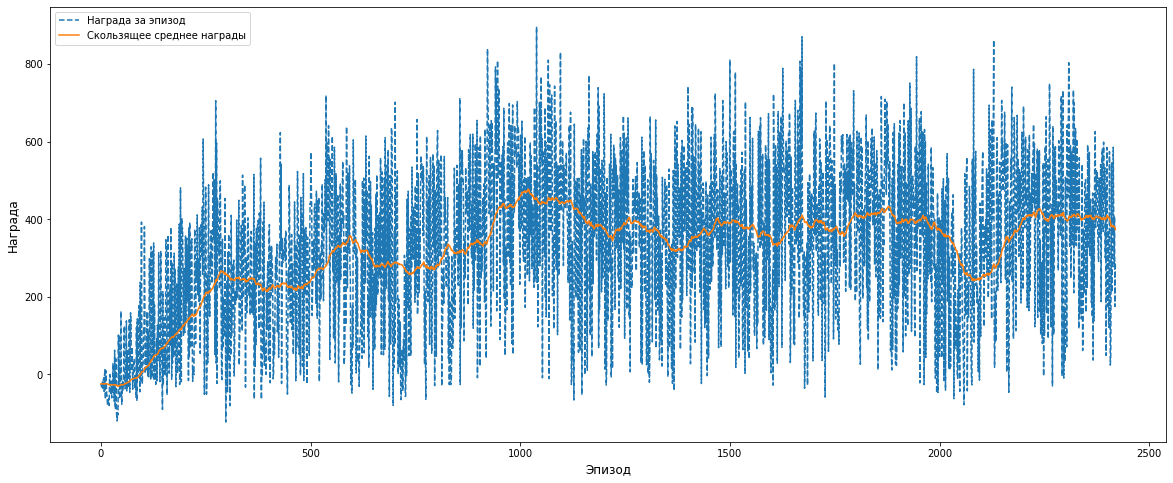

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1241..1555 -> 314-tiles track


In [ ]:
load_pretrained = False  #Переменная, которая указывает если мы хотим запускать обучение с нуля (False) или продолжать с ранее сохраненного прогресса (True)

env = gym.make(env_name) #Создаем объект игровой среды
if load_pretrained:      #Если мы ранее указали что хотим продолжить обучение:
  all_episode_rewards = load_training_progress() #Загружаем ранее сохраненный прогресс
else:                    #Иначе (обучение начинается с нуля):
  all_episode_rewards = []                       #Инициализируем пустой список, где будем хранить суммарные награды за каждый эпизод

episode_reward = 0                               #Инициализируем суммарную награду за эпизод как 0
observation = preprocess_image(env.reset())      #Начинаем эпизод, получаем первый кадр и обрабатываем его через функцию preprocess_image
while True:      #Запускаем бесконечный цикл, в которым агент взаимодействует с средой и обучается
  current_state = next_state = np.stack([observation] * num_frames, axis = 2).squeeze() #Склеиваем кадр по каналам num_frames раз, чтобы создать единный массив

  batch_current_states = []          #Создаем пустой список где будем хранить все текущие состояния с пакета   (s)
  batch_next_states = []             #Создаем пустой список где будем хранить все следующие состояния с пакета (s')
  batch_actions = []                 #Создаем пустой список где будем хранить все действия, которые агент принимает 
  batch_rewards = []                 #Создаем пустой список где будем хранить все награды, которые агент получает
  batch_dones = []                   #Создаем пустой список где будем хранить все статусы завершения эпизода на каждый момент в пакете
  batch_log_maximum_likelihoods = []    #Создаем пустой список где будем хранить все оценки правдоподобия (между действиями до и после добавления шума)

  #Дальше мы собираем пакет данных в цикле, и после завершения цикла, обучаем нейронную сеть.
  #Нужно отметить, что этот алгоритм НЕ обучается на эпизодах по отдельности. Один может содержать несколько эпизодов, в том числе и отрезки от одного эпизода.
  #Можно даже обучать алгоритм так, чтобы пакет был намного меньше, чем длина эпизода (но это не рекоммендуется).
  
  for i in range(batch_size):     #Собираем нужные данные для пакета в внутреннем цикле        
    actions, log_maximum_likelihoods = choose_action(current_state)   #Используем функцию выбора действий чтобы получить массив действий и оценку правдободобий
    observation, reward, done, info = make_multiple_steps(actions) #Подаем действие в самописную функцию, чтобы агент предпринял это действие несколько раз
    episode_reward += reward #Добавляем полученную награду к счетчику, который считает суммарную награду за эпизод
    
    observation = preprocess_image(observation) #Предобрабатываем кадр, который получаем в результате принятия действий
    next_state = np.append(observation, next_state[:, :, :num_frames-1], axis = 2) #Соеденяемпредобработанный кадр с массивом следующего состояния

    batch_current_states.append(current_state)              #Добавляем текущее состояние в соответствующий список
    batch_next_states.append(next_state)                    #Добавляем следующее состояние в соответствующий список
    batch_actions.append(actions.flatten())                 #Добавляем массив действий в соответствующий список (и выравниваем чтобы там были правильные размерности)
    batch_rewards.append(reward)                            #Добавляем награду в соответствующий список
    batch_dones.append(done)                                #Добавляем статус завершения эпизода соответствующий список
    batch_log_maximum_likelihoods.append(log_maximum_likelihoods) #Добавляем оценку правпободобия

    current_state = next_state              #Обновляем текущее состояние под следующее состояние

    if done:        #Если эпизод завершается на этом моменте:
      all_episode_rewards.append(episode_reward) #Добавляем суммарную награду за эпизод в массив
      done, episode_reward = False, 0            #Обновляем значения параметров done и episode_reward для начала нового эпизода

      env.close()     #Закрываем игровую среду (это нужно делать чтобы не было ошибки ОЗУ из-за утечки памяти внутри среды)
      gc.collect()    #Удаляем мусорные данные (как дополнительная мера избежания ошибок ОЗУ)

      env = gym.make(env_name)  #Заново создаем игровую среду
      observation = preprocess_image(env.reset()) #Запускаем новый эпизод и предобрабатываем полученный кадр

      if len(all_episode_rewards) % 10 == 0: #Раз в 10 игровых эпизодов:
        save_training_progress()             #Сохраняем прогресс обучения
        show_scores(all_episode_rewards)     #Отображаем график полученных наград

  train_algorithm(batch_current_states, batch_actions, batch_rewards, batch_next_states, batch_dones, batch_log_maximum_likelihoods) #Обучаем алгоритм в конце пакета

#Записываем результат в видео

После того как мы обучили агента, мы хотим посмотреть на результат его работы. Для этого, мы создадим видео. Суть этого кода такая же, как и аналогичного кода в каждом занятии.

ПРИМЕЧАНИЕ: Если запускать этот код в той же сессии, что и обучение, есть возможность что колаб слетит. В таком случае, просто запустите все предыдущие ячейки КРОМЕ ячейки с обучением агента, а затем запустите эту ячейку.

In [ ]:
video_frames = []        #Создаем пустой список, куда будем записывать каждый кадр

if 'env' in globals():   #Если переменная env уже объявлена (т.е. код с обучением агента запускался и прервался)
  env.close()            #Закрываем среду, чтобы избежать ошибок колаба

env = gym.make(env_name) #Создаем среду

actor_model = Actor_Critic_Model(model_type = 'actor')        #Создаем объект модели актёра
critic_model = Actor_Critic_Model(model_type = 'critic')      #Создаем объект модели критика
load_training_progress()                                      #Загружаем предобученые веса в модели
done = False        #Указываем что эпизод не завершен

observation = preprocess_image(env.reset()) #Получаем первый кадр, предобрабатываем его
current_state = np.stack([observation] * num_frames, axis = 2).squeeze() #Склеиваем кадр на себя несколько раз чтобы получить состояние

while not done:   #Запускаем цикл с условием - пока эпизод не завершен:
  actions, log_maximum_likelihood = choose_action(current_state)        #Подаем текущее состояние в актёра (указываем что больше не нужно добавлять шум в выход)
  observation, reward, done, info = make_multiple_steps(actions)  #Подаем действие в самописную функцию, чтобы агент предпринял это действие несколько раз

  resized_observation = cv2.resize(observation, (480, 480), interpolation=cv2.INTER_CUBIC) #Меняем размер картинки (делаем размер больше для воспроизведение видео)
  video_frames.append(resized_observation)    #Добавляем большую картинку в массив кадров видео
    
  observation = preprocess_image(observation) #Обрабатываем следующей полученный кадр
  current_state = np.append(observation, current_state[:, :, :num_frames-1], axis = 2) #Добавляем кадр в новое состояние

env.close() #Закрываем среду после завершения эпизода

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1200..1504 -> 304-tiles track


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Далее, записываем результат в видео (данный код присутствует в других занятиях).

In [ ]:
#Создаем объект для воспроизведение видео (задаем путь к файлу видео, формат видео, кадры в секунду, и размер изображений)
out = cv2.VideoWriter('/content/episode.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, (480, 480)) #Чем больше кадров в секунду, тем быстрее видео будет проигрываться
for i in range(len(video_frames)):   #В цикле добавляем каждый кадр в видео (делаем предобработку кадра - меняем каналы с RGB в BGR - это нужно потому что cv2 воспринимает каналы как BGR)
  out.write(cv2.cvtColor(video_frames[i], cv2.COLOR_RGB2BGR))
out.release()   #Закрываем объект для создания видео

И наконец то, отображаем видео в колабе и смотрим на результат работы обученного агента!

In [ ]:
!pip install imageio==2.4.1

In [ ]:
from moviepy.editor import *                                      #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
path="/content/episode.avi" #Указываем путь к видео

clip=VideoFileClip(path)    #Извлекаем видео из заданного пути (куда мы ранее записыли видео через cv2)
clip.ipython_display(width = 480, maxduration = 100) #Отображаем видео в колабе

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2777088/45929032 bytes (6.0%)5095424/45929032 bytes (11.1%)6905856/45929032 bytes (15.0%)9887744/45929032 bytes (21.5%)12836864/45929032 bytes (27.9%)15433728/45929032 bytes (33.6%)18128896/45929032 bytes (39.5%)20742144/45929032 bytes (45.2%)22331392/45929032 bytes (48.6%)25108480/45929032 bytes (54.7%)27303936/45929032 bytes (59.4%)28868608/45929032 bytes (62.9%)3

100%|██████████| 125/125 [00:01<00:00, 119.95it/s]
